# Database

In [1]:
# Imports
from functions import *
from models import *
from bayespy import nodes
from bayespy.inference import VB
# seed
set_seed(2020)

Using TensorFlow backend.


Load and prepare Breast Cancer database

In [2]:
# Column names
col_names = ["id","diagnosis","radius_mean","texture_mean","perimeter_mean","area_mean","smoothness_mean","compactness_mean","concavity_mean","concave points_mean","symmetry_mean","fractal_dimension_mean","radius_se","texture_se","perimeter_se","area_se","smoothness_se","compactness_se","concavity_se","concave points_se","symmetry_se","fractal_dimension_se","radius_worst","texture_worst","perimeter_worst","area_worst","smoothness_worst","compactness_worst","concavity_worst","concave points_worst","symmetry_worst","fractal_dimension_worst"]
# Reading dataset
dataset = pd.read_csv('../dataset/wdbc.data', header=None, names= col_names)
X = dataset.drop(['id','diagnosis'], axis=1)
y = dataset['diagnosis']

# Constants

In [3]:
# Ammount of samples
n_samples = X.shape[0]
# Observed space dimensionality
dim = X.shape[1]
# Ammount of classes
n_classes = len(y.unique())

# BayesPy

## Model definition

Mean and precision distribucion defined as
$$
\mu \sim \mathcal{N}_{dim}(0,I) \quad \text{and} \quad \Lambda \sim \mathcal{W}(dim,I_{dim}).
$$

Mixture weights follow a Dirichlet distribution
$$
    \pi \sim \text{Symmetric-Dirichlet}\Big(\frac{1}{n\_components}\Big).
$$

The variable modeling the component assignation follows a categorical distribution as
$$
    Z_n \sim \text{Categorical}(\pi).
$$

In [4]:
# Define a functoin that returns all the variables of the model.
def GaussianMixture(dim, n_components, n_samples):
    Lambda = nodes.Wishart(dim, np.identity(dim), plates=(n_components,))
    mu = nodes.Gaussian(np.zeros(dim), np.identity(dim), plates=(n_components,))
    pi = nodes.Dirichlet(np.ones(n_components)/n_components)
    z = nodes.Categorical(pi, plates=(n_samples,))
    x = nodes.Mixture(z, nodes.Gaussian, mu, Lambda)

    return x, z, pi, mu, Lambda

## Breast Cancer Diagnosys

Define the new variables

In [5]:
x, z, pi, mu, Lambda = GaussianMixture(dim = X.shape[1], 
                                       n_components = len(y.unique()), 
                                       n_samples = X.shape[0])

Observe the given dataset, `Pandas' dataframe` can't be used. They raise a dimensionality error.

In [6]:
x.observe(X.to_numpy())

Create the inference object.

In [7]:
Q = VB(x, mu, z, Lambda, pi)

Initialize `z` using random values as letting the default initialization (prior) leads to 4 simmilar normal distributions.

In [8]:
z.initialize_from_random()

Start learning.

In [9]:
Q.update(repeat=1000)

Iteration 1: loglike=-1.229165e+06 (0.049 seconds)
Iteration 2: loglike=-6.573372e+03 (0.048 seconds)
Iteration 3: loglike=-4.811194e+03 (0.051 seconds)
Iteration 4: loglike=-4.195404e+03 (0.044 seconds)
Iteration 5: loglike=-3.934526e+03 (0.042 seconds)
Iteration 6: loglike=-3.685506e+03 (0.047 seconds)
Iteration 7: loglike=-3.414732e+03 (0.043 seconds)
Iteration 8: loglike=-3.123762e+03 (0.041 seconds)
Iteration 9: loglike=-2.913217e+03 (0.041 seconds)
Iteration 10: loglike=-2.764515e+03 (0.041 seconds)
Iteration 11: loglike=-2.630799e+03 (0.044 seconds)
Iteration 12: loglike=-2.523561e+03 (0.045 seconds)
Iteration 13: loglike=-2.456218e+03 (0.041 seconds)
Iteration 14: loglike=-2.414676e+03 (0.043 seconds)
Iteration 15: loglike=-2.393060e+03 (0.042 seconds)
Iteration 16: loglike=-2.365463e+03 (0.044 seconds)
Iteration 17: loglike=-2.321662e+03 (0.045 seconds)
Iteration 18: loglike=-2.309745e+03 (0.042 seconds)
Iteration 19: loglike=-2.284863e+03 (0.041 seconds)
Iteration 20: loglike

Iteration 160: loglike=-2.005584e+03 (0.045 seconds)
Iteration 161: loglike=-2.005494e+03 (0.048 seconds)
Iteration 162: loglike=-2.005405e+03 (0.043 seconds)
Iteration 163: loglike=-2.005317e+03 (0.045 seconds)
Iteration 164: loglike=-2.005231e+03 (0.045 seconds)
Iteration 165: loglike=-2.005146e+03 (0.048 seconds)
Iteration 166: loglike=-2.005062e+03 (0.044 seconds)
Iteration 167: loglike=-2.004980e+03 (0.045 seconds)
Iteration 168: loglike=-2.004899e+03 (0.043 seconds)
Iteration 169: loglike=-2.004818e+03 (0.044 seconds)
Iteration 170: loglike=-2.004739e+03 (0.046 seconds)
Iteration 171: loglike=-2.004662e+03 (0.047 seconds)
Iteration 172: loglike=-2.004585e+03 (0.044 seconds)
Iteration 173: loglike=-2.004510e+03 (0.043 seconds)
Iteration 174: loglike=-2.004435e+03 (0.043 seconds)
Iteration 175: loglike=-2.004362e+03 (0.047 seconds)
Iteration 176: loglike=-2.004289e+03 (0.044 seconds)
Iteration 177: loglike=-2.004218e+03 (0.047 seconds)
Iteration 178: loglike=-2.004148e+03 (0.043 se

Each component probability may be inspected using `pi`.

In [10]:
print(pi)

 ~ Dirichlet(alpha)
  alpha =
[  6.5 563.5]


`Z` models each datapoint belongint to each component and its first moment equals this exact probability.

In [49]:
print(z.u[0][y == "B"])

[[9.62479862e-01 3.75201375e-02]
 [9.78739533e-01 2.12604671e-02]
 [9.46148481e-01 5.38515194e-02]
 [6.58789569e-01 3.41210431e-01]
 [9.02383248e-01 9.76167517e-02]
 [9.61289267e-01 3.87107333e-02]
 [9.67333731e-01 3.26662685e-02]
 [9.80165118e-01 1.98348824e-02]
 [9.58803055e-01 4.11969450e-02]
 [9.80474911e-01 1.95250894e-02]
 [9.78024326e-01 2.19756737e-02]
 [9.76935958e-01 2.30640424e-02]
 [9.25782650e-01 7.42173495e-02]
 [9.64446810e-01 3.55531903e-02]
 [9.20447351e-01 7.95526493e-02]
 [9.46709681e-01 5.32903187e-02]
 [9.51021140e-01 4.89788603e-02]
 [9.77642864e-01 2.23571361e-02]
 [9.39275359e-01 6.07246405e-02]
 [9.33956407e-01 6.60435935e-02]
 [9.32347324e-01 6.76526762e-02]
 [9.58207945e-01 4.17920554e-02]
 [7.79044262e-01 2.20955738e-01]
 [9.78466526e-01 2.15334743e-02]
 [9.57368383e-01 4.26316173e-02]
 [9.77465510e-01 2.25344904e-02]
 [9.69896649e-01 3.01033509e-02]
 [9.78851341e-01 2.11486590e-02]
 [9.39782585e-01 6.02174152e-02]
 [9.41482483e-01 5.85175171e-02]
 [1.247954

Each component membership can be therefore plotted using this data.

/home/ludvins/.pyenv/versions/3.6.9/envs/InferPy/lib/python3.6/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


<Figure size 432x288 with 0 Axes>

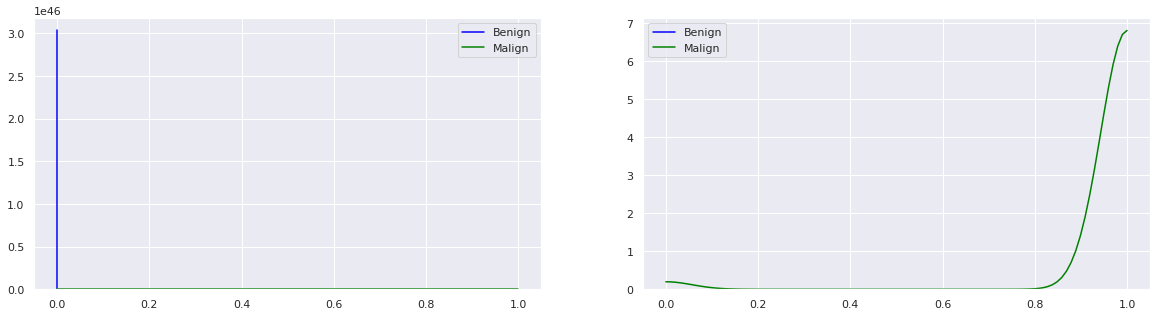

In [12]:
plot_mixture_distplot([z.u[0][y=="B"],z.u[0][y=="M"]], ["Benign", "Malign"], ["blue","green"], 
                      n_components = n_classes)

We might generate a posterior sample using `random()`.

In [13]:
print(x.random())

[[ 0.0743429   0.00527335  0.03188536 ...  0.22342627 -0.00308106
   0.25700646]
 [-0.20450711  0.09625717  0.23256486 ... -0.14408407 -0.20263355
  -0.06837617]
 [ 0.2995369  -0.2177071  -0.00289559 ... -0.08487693 -0.00755265
  -0.10025784]
 ...
 [-0.00974389 -0.15705131 -0.01358923 ...  0.05708143  0.20126379
  -0.01745082]
 [-0.3000618  -0.13105361  0.20172223 ... -0.09875572 -0.02680159
  -0.04544714]
 [ 0.22298444  0.16012556  0.03350916 ... -0.01141511 -0.34832426
  -0.09770239]]


## Reduced space

We might use a vae to reduce the data to a two-dimensional space.

In [14]:
vae_model = vae(2, 100, dim)
q_vae = Q_vae(2, 100, dim)

optimizer = tf.train.AdamOptimizer(0.01)
VI_vae = inf.inference.VI(q_vae, optimizer=optimizer, epochs=4000)
vae_model.fit({"x": X}, VI_vae)
data = vae_model.posterior("z", data={"x": X}).sample()


 0 epochs	 504412128.0....................
 200 epochs	 6163732.0....................
 400 epochs	 1965005.875....................
 600 epochs	 1292843.875....................
 800 epochs	 911255.0....................
 1000 epochs	 731195.25....................
 1200 epochs	 618658.75....................
 1400 epochs	 551460.0625....................
 1600 epochs	 781488.9375....................
 1800 epochs	 480570.8125....................
 2000 epochs	 410057.6875....................
 2200 epochs	 377567.4375....................
 2400 epochs	 348210.03125....................
 2600 epochs	 329420.78125....................
 2800 epochs	 312858.1875....................
 3000 epochs	 309560.71875....................
 3200 epochs	 297279.78125....................
 3400 epochs	 300119.59375....................
 3600 epochs	 372105.65625....................
 3800 epochs	 260840.1875....................

We define the new mixture model and initialize training.

In [55]:
x, z, pi, mu, Lambda = GaussianMixture(dim = data.shape[1], 
                                       n_components = len(y.unique()), 
                                       n_samples = X.shape[0])
x.observe(data)
Q = VB(x, mu, z, Lambda, pi)
z.initialize_from_random()
Q.update(repeat=1000)

Iteration 1: loglike=-4.200135e+03 (0.006 seconds)
Iteration 2: loglike=-3.833744e+03 (0.006 seconds)
Iteration 3: loglike=-3.782325e+03 (0.006 seconds)
Iteration 4: loglike=-3.762479e+03 (0.010 seconds)
Iteration 5: loglike=-3.750912e+03 (0.006 seconds)
Iteration 6: loglike=-3.744867e+03 (0.007 seconds)
Iteration 7: loglike=-3.741921e+03 (0.006 seconds)
Iteration 8: loglike=-3.740426e+03 (0.005 seconds)
Iteration 9: loglike=-3.739595e+03 (0.006 seconds)
Iteration 10: loglike=-3.739100e+03 (0.005 seconds)
Iteration 11: loglike=-3.738793e+03 (0.006 seconds)
Iteration 12: loglike=-3.738599e+03 (0.006 seconds)
Iteration 13: loglike=-3.738475e+03 (0.006 seconds)
Iteration 14: loglike=-3.738395e+03 (0.005 seconds)
Iteration 15: loglike=-3.738344e+03 (0.006 seconds)
Iteration 16: loglike=-3.738311e+03 (0.005 seconds)
Converged at iteration 16.


In this case, `pi` has correctly learn each component probability.

In [56]:
print(pi)

 ~ Dirichlet(alpha)
  alpha =
[353.13858066 216.86141934]


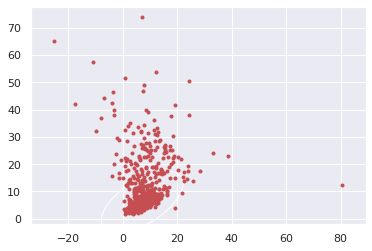

In [57]:
bpplt.gaussian_mixture_2d(x, alpha=pi, scale=5)
bpplt.pyplot.show()

<Figure size 432x288 with 0 Axes>

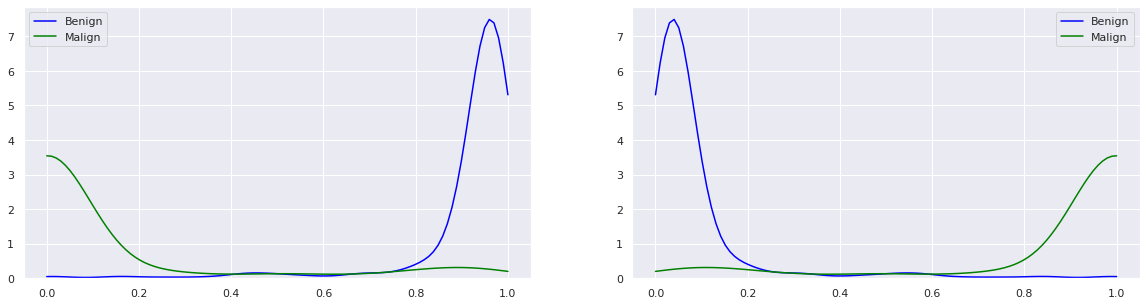

In [58]:
plot_mixture_distplot([z.u[0][y=="B"],z.u[0][y=="M"]], ["Benign", "Malign"], ["blue","green"], 
                      n_components = n_classes)